# Imports

In [44]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
from matplotlib import pyplot as plt
%matplotlib inline

# Data

In [10]:
#quora question pairs-kaggle
df = pd.read_csv("/home/uv/Downloads/train.csv",nrows=1000)
df.shape

(1000, 6)

In [12]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


# Infersent Model

In [2]:
class InferSent(nn.Module):

    def __init__(self, config):
        super(InferSent, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']
        self.version = 1 if 'version' not in config else config['version']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)

        assert self.version in [1, 2]
        if self.version == 1:
            self.bos = '<s>'
            self.eos = '</s>'
            self.max_pad = True
            self.moses_tok = False
        elif self.version == 2:
            self.bos = '<p>'
            self.eos = '</p>'
            self.max_pad = False
            self.moses_tok = True

    def is_cuda(self):
        # either all weights are on cpu or they are on gpu
        return self.enc_lstm.bias_hh_l0.data.is_cuda

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (bsize)
        # sent: (seqlen x bsize x worddim)
        sent, sent_len = sent_tuple
        print(sent.shape,sent_len.shape)
        # Sort by length (keep idx)
        sent_len_sorted, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent_len_sorted = sent_len_sorted.copy()
        idx_unsort = np.argsort(idx_sort)

        idx_sort = torch.from_numpy(idx_sort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_sort)
        sent = sent.index_select(1, idx_sort)

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len_sorted)
        print("sentpacked",sent_packed)
        print("sent_sorted",sent_len_sorted)
        sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]

        # Un-sort by length
        idx_unsort = torch.from_numpy(idx_unsort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_unsort)
        sent_output = sent_output.index_select(1, idx_unsort)
        print("sent_output",sent_output.shape)

        # Pooling
        if self.pool_type == "mean":
            sent_len = torch.FloatTensor(sent_len.copy()).unsqueeze(1).cuda()
            emb = torch.sum(sent_output, 0).squeeze(0)
            emb = emb / sent_len.expand_as(emb)
        elif self.pool_type == "max":
            if not self.max_pad:
                sent_output[sent_output == 0] = -1e9
            emb = torch.max(sent_output, 0)[0]
            if emb.ndimension() == 3:
                emb = emb.squeeze(0)
                assert emb.ndimension() == 2

        return emb

    def set_w2v_path(self, w2v_path):
        self.w2v_path = w2v_path

    def get_word_dict(self, sentences, tokenize=True):
        # create vocab of words
        word_dict = {}
        sentences = [s.split() if not tokenize else self.tokenize(s) for s in sentences]
        print("sentences after tokenization",sentences)
        for sent in sentences:
            for word in sent:
                if word not in word_dict:
                    word_dict[word] = ''
        word_dict[self.bos] = ''
        word_dict[self.eos] = ''
        return word_dict

    def get_w2v(self, word_dict):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with w2v vectors
        word_vec = {}
        with open(self.w2v_path, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if word in word_dict:
                    word_vec[word] = np.fromstring(vec, sep=' ')
        print('Found %s(/%s) words with w2v vectors' % (len(word_vec), len(word_dict)))
        print("word_vec",word_vec.keys())
        return word_vec

    def get_w2v_k(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with k first w2v vectors
        k = 0
        word_vec = {}
        with open(self.w2v_path, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if k <= K:
                    word_vec[word] = np.fromstring(vec, sep=' ')
                    k += 1
                if k > K:
                    if word in [self.bos, self.eos]:
                        word_vec[word] = np.fromstring(vec, sep=' ')

                if k > K and all([w in word_vec for w in [self.bos, self.eos]]):
                    break
        return word_vec

    def build_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        word_dict = self.get_word_dict(sentences, tokenize)
        self.word_vec = self.get_w2v(word_dict)
        print('Vocab size : %s' % (len(self.word_vec)))
        #print(self.word_vec)

    # build w2v vocab with k most frequent words
    def build_vocab_k_words(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        self.word_vec = self.get_w2v_k(K)
        print('Vocab size : %s' % (K))

    def update_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'warning : w2v path not set'
        assert hasattr(self, 'word_vec'), 'build_vocab before updating it'
        word_dict = self.get_word_dict(sentences, tokenize)

#         # keep only new words
#         for word in self.word_vec:
#             if word in word_dict:
#                 del word_dict[word]

        # udpate vocabulary
        if word_dict:
            new_word_vec = self.get_w2v(word_dict)
            self.word_vec.update(new_word_vec)
        else:
            new_word_vec = []
        print('New vocab size : %s (added %s words)'% (len(self.word_vec), len(new_word_vec)))

    def get_batch(self, batch):
        # sent in batch in decreasing order of lengths
        # batch: (bsize, max_len, word_dim)
        embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))
        print("embed",embed.shape)
        for i in range(len(batch)):
            for j in range(len(batch[i])):
                embed[j, i, :] = self.word_vec[batch[i][j]]

        return torch.FloatTensor(embed)

    def tokenize(self, s):
        from nltk.tokenize import word_tokenize
        if self.moses_tok:
            s = ' '.join(word_tokenize(s))
            s = s.replace(" n't ", "n 't ")  # HACK to get ~MOSES tokenization
            return s.split()
        else:
            return word_tokenize(s)

    def prepare_samples(self, sentences, bsize, tokenize, verbose):
        sentences = [[self.bos] + s.split() + [self.eos] if not tokenize else
                     [self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
        n_w = np.sum([len(x) for x in sentences])

        # filters words without w2v vectors
        for i in range(len(sentences)):
            s_f = [word for word in sentences[i] if word in self.word_vec]
            if not s_f:
                import warnings
                warnings.warn('No words in "%s" (idx=%s) have w2v vectors. \
                               Replacing by "</s>"..' % (sentences[i], i))
                s_f = [self.eos]
            sentences[i] = s_f

        lengths = np.array([len(s) for s in sentences])
        n_wk = np.sum(lengths)
        if verbose:
            print('Nb words kept : %s/%s (%.1f%s)' % (
                        n_wk, n_w, 100.0 * n_wk / n_w, '%'))

        # sort by decreasing length
        lengths, idx_sort = np.sort(lengths)[::-1], np.argsort(-lengths)
        sentences = np.array(sentences)[idx_sort]

        return sentences, lengths, idx_sort

    def encode(self, sentences, bsize=64, tokenize=True, verbose=False):
        tic = time.time()
        sentences, lengths, idx_sort = self.prepare_samples(
                        sentences, bsize, tokenize, verbose)   #[[sentense1_tokens],["sentense_2_tokens"]]
                                                               # [sent1_len,sent2_len]
                                                               # [flagofsentence]

        print(f"Sentences:{sentences}, length{lengths},idx_sort{idx_sort}")
        embeddings = []
        for stidx in range(0, len(sentences), bsize):
            print("stidx",stidx)
            print("before_get_batch",sentences[stidx:stidx + bsize])
            batch = self.get_batch(sentences[stidx:stidx + bsize])
            print("batch",batch,batch.shape)
            if self.is_cuda():
                batch = batch.cuda()
            with torch.no_grad():
                batch = self.forward((batch, lengths[stidx:stidx + bsize])).data.cpu().numpy()
                print(batch.shape)
            embeddings.append(batch)
        embeddings = np.vstack(embeddings)

        # unsort
        idx_unsort = np.argsort(idx_sort)
        embeddings = embeddings[idx_unsort]

        if verbose:
            print('Speed : %.1f sentences/s (%s mode, bsize=%s)' % (
                    len(embeddings)/(time.time()-tic),
                    'gpu' if self.is_cuda() else 'cpu', bsize))
        return embeddings

    def visualize(self, sent, tokenize=True):

        sent = sent.split() if not tokenize else self.tokenize(sent)
        sent = [[self.bos] + [word for word in sent if word in self.word_vec] + [self.eos]]

        if ' '.join(sent[0]) == '%s %s' % (self.bos, self.eos):
            import warnings
            warnings.warn('No words in "%s" have w2v vectors. Replacing \
                           by "%s %s"..' % (sent, self.bos, self.eos))
        batch = self.get_batch(sent)

        if self.is_cuda():
            batch = batch.cuda()
        output = self.enc_lstm(batch)[0]
        output, idxs = torch.max(output, 0)
        # output, idxs = output.squeeze(), idxs.squeeze()
        idxs = idxs.data.cpu().numpy()
        argmaxs = [np.sum((idxs == k)) for k in range(len(sent[0]))]

        # visualize model
        import matplotlib.pyplot as plt
        x = range(len(sent[0]))
        y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
        plt.xticks(x, sent[0], rotation=45)
        plt.bar(x, y)
        plt.ylabel('%')
        plt.title('Visualisation of words importance')
        plt.show()

        return output, idxs, x, y,sent


# Sentence Embedding

In [3]:
model_version = 2
MODEL_PATH = "/home/uv/Documents/document_embedding/encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [4]:
# Keep it on CPU or put it on GPU
use_cuda = False
model = model.cuda() if use_cuda else model

In [19]:
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else '/home/uv/Documents/document_embedding/fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [23]:
sample = df[df.is_duplicate==1][:2]
sample

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1


In [24]:
model.build_vocab(sample.question1.values)

sentences after tokenization [['Astrology', ':', 'I', 'am', 'a', 'Capricorn', 'Sun', 'Cap', 'moon', 'and', 'cap', 'rising', '...', 'what', 'does', 'that', 'say', 'about', 'me', '?'], ['How', 'can', 'I', 'be', 'a', 'good', 'geologist', '?']]
Found 27(/27) words with w2v vectors
word_vec dict_keys(['and', 'a', 'that', 'I', ':', '?', 'be', '...', 'can', 'about', 'what', 'me', 'good', 'say', 'does', 'am', 'How', 'Sun', 'cap', 'moon', 'rising', 'Cap', 'Astrology', 'Capricorn', 'geologist', '</p>', '<p>'])
Vocab size : 27


In [38]:
embedding = model.encode(sample.question1.values,tokenize=True)

Sentences:[list(['<p>', 'Astrology', ':', 'I', 'am', 'a', 'Capricorn', 'Sun', 'Cap', 'moon', 'and', 'cap', 'rising', '...', 'what', 'does', 'that', 'say', 'about', 'me', '?', '</p>'])
 list(['<p>', 'How', 'can', 'I', 'be', 'a', 'good', 'geologist', '?', '</p>'])], length[22 10],idx_sort[0 1]
stidx 0
before_get_batch [list(['<p>', 'Astrology', ':', 'I', 'am', 'a', 'Capricorn', 'Sun', 'Cap', 'moon', 'and', 'cap', 'rising', '...', 'what', 'does', 'that', 'say', 'about', 'me', '?', '</p>'])
 list(['<p>', 'How', 'can', 'I', 'be', 'a', 'good', 'geologist', '?', '</p>'])]
embed (22, 2, 300)
batch tensor([[[-0.3398,  0.3010,  0.1689,  ...,  0.0639,  0.0120, -0.1761],
         [-0.3398,  0.3010,  0.1689,  ...,  0.0639,  0.0120, -0.1761]],

        [[-0.1706,  0.4861,  0.8041,  ...,  0.1317,  0.1522,  0.0472],
         [ 0.2556,  0.2020,  0.1471,  ...,  0.4596,  0.0446, -0.1606]],

        [[-0.0731,  0.0320,  0.0507,  ...,  0.0880, -0.0027,  0.1899],
         [-0.1720,  0.0026, -0.0409,  ...,  

In [39]:
embedding.shape

(2, 4096)

In [40]:
cosine_similarity(embedding)

array([[0.9999995, 0.3336536],
       [0.3336536, 1.0000004]], dtype=float32)

In [41]:
embedding2 = model.encode(sample.question2.values,tokenize=True)

Sentences:[list(['<p>', 'I', 'a', 'Capricorn', 'Sun', 'and', 'Capricorn', 'does', 'say', 'about', 'me', '?', '</p>'])
 list(['<p>', 'I', 'be', 'a', 'geologist', '?', '</p>'])], length[13  7],idx_sort[0 1]
stidx 0
before_get_batch [list(['<p>', 'I', 'a', 'Capricorn', 'Sun', 'and', 'Capricorn', 'does', 'say', 'about', 'me', '?', '</p>'])
 list(['<p>', 'I', 'be', 'a', 'geologist', '?', '</p>'])]
embed (13, 2, 300)
batch tensor([[[-0.3398,  0.3010,  0.1689,  ...,  0.0639,  0.0120, -0.1761],
         [-0.3398,  0.3010,  0.1689,  ...,  0.0639,  0.0120, -0.1761]],

        [[-0.1615, -0.0980,  0.0185,  ...,  0.0735, -0.0265, -0.1398],
         [-0.1615, -0.0980,  0.0185,  ...,  0.0735, -0.0265, -0.1398]],

        [[ 0.0064,  0.0333,  0.0225,  ..., -0.0825,  0.0519, -0.0796],
         [-0.1151, -0.1231,  0.0115,  ..., -0.3133,  0.0388,  0.0048]],

        ...,

        [[-0.2161, -0.2337,  0.0548,  ..., -0.1334, -0.0926, -0.1469],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  

In [42]:
embed = np.vstack([embedding,embedding2])

In [43]:
cosine_similarity(embed)

array([[0.9999995 , 0.3336536 , 0.7530447 , 0.19622421],
       [0.3336536 , 1.0000004 , 0.3960089 , 0.79095197],
       [0.7530447 , 0.3960089 , 1.0000005 , 0.31975242],
       [0.19622421, 0.79095197, 0.31975242, 1.0000001 ]], dtype=float32)

embed (21, 1, 300)


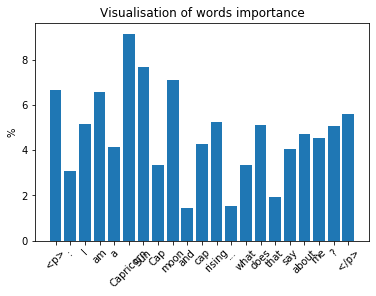

In [48]:
_,_,x,y,sent = model.visualize(str(sample.question1[:1].values),tokenize=True)

In [49]:
[(y[i],j) for i,j in enumerate(sent[0])]

[(6.6650390625, '<p>'),
 (3.076171875, ':'),
 (5.1513671875, 'I'),
 (6.591796875, 'am'),
 (4.150390625, 'a'),
 (9.1796875, 'Capricorn'),
 (7.71484375, 'Sun'),
 (3.369140625, 'Cap'),
 (7.1044921875, 'moon'),
 (1.46484375, 'and'),
 (4.2724609375, 'cap'),
 (5.2490234375, 'rising'),
 (1.5380859375, '...'),
 (3.3447265625, 'what'),
 (5.126953125, 'does'),
 (1.9287109375, 'that'),
 (4.0771484375, 'say'),
 (4.736328125, 'about'),
 (4.541015625, 'me'),
 (5.1025390625, '?'),
 (5.615234375, '</p>')]

# Reference

1. [Facebook-Infersent](https://github.com/facebookresearch/InferSent)